# Energy conservation

**Different options**
1. "Culprit" variable
2. Additive correction
3. Multiplicative correction (doesn't seem to fit)
4. After-the-fact post-processing (not tried yet)

**Radiation**

- vint(QRL)\*C_P + vint(QRS)\*C_P = FSNT - FSNS - FLNT - FLNS

**MSE**

- vint(TPHYSTND_NORAD)\*C_P + vint(PHQ)\*L_S + vint(PHCLDICE)\*L_I = vint(DTV)\*C_P + vint(VD01)\*L_S + dPREC
- dPREC = (PRECSC + PRECSL)\*1e3 + PRECSTEN - (PRECT\*1e3 + PRECTEND))\*L_I

**Moisture**

- PRECT + PRECTEND\*1e-3 = vint(SPDQ) + vint(SPDCQ) + vint(SPDQI) = vint(PHQ) - vint(VD01) + vint(PHCLDLIQ) + vint(PHCLDICE)

**ToDo**

1. Test post-processing option for radiation and compare the 4 options
1. Do the same for MSE
1. Then the same for moisture
1. Clean up and combine all of the options
1. Test again before implementation in scripts

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from keras.layers import *
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def concat_ds(ds, vars, fact=None):
    arr = []
    for i, v in enumerate(vars):
        da = ds[v].values.copy()
        if fact is not None: da *= fact[i]
        arr.append(np.expand_dims(da, 1) if da.ndim==3 else da)
    arr = np.concatenate(arr, 1)
    return np.rollaxis(arr, 1, 4).reshape(-1, arr.shape[1])

In [9]:
dt = 1800

In [25]:
ngeo = 64*128
def split(f, t, nt=40):
    return f[:nt*ngeo], f[nt*ngeo:], t[:nt*ngeo], t[nt*ngeo:]

## MSE conservation

In [71]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [72]:
print(sorted(list(ds.data_vars.keys())))

['DTV', 'DTVKE', 'FLUT', 'LHFLX', 'OMEGA', 'P0', 'PHCLDICE', 'PHCLDLIQ', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QBP', 'QCAP', 'QIAP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDQC', 'SPDQI', 'SPDT', 'SPQC', 'SPQI', 'SRFRAD', 'T', 'TAP', 'TBP', 'TPHYSTND', 'TPHYSTND_NORAD', 'TS', 'UAP', 'UPHYSTND', 'VAP', 'VD01', 'VPHYSTND', 'dQdt_adiabatic', 'dTdt_adiabatic', 'date', 'date_written', 'datesec', 'gw', 'hyai', 'hyam', 'hybi', 'hybm', 'mdt', 'nbdate', 'nbsec', 'ndbase', 'ndcur', 'nlon', 'nsbase', 'nscur', 'nsteph', 'ntrk', 'ntrm', 'ntrn', 'time_bnds', 'time_written', 'wnummax']


In [73]:
# Add NORAD term to dataset
ds['TPHYSTND_NORAD'] = ds.TPHYSTND - ds.QRL - ds.QRS

In [74]:
ds = ds.isel(time=slice(1, None))

### Energy conservation from raw data

- TPHYSTND = SPDT + QRL + QRS + DTV(t-1)
- DTV = SHFLX / C_P / dt

vint(TPHYSTND) + vint(PHQ) = SHFLX + LHFLX + engy(PREC) 

#### Check assumptions

In [180]:
def rel_hist(left, right):
    left = left.values
    right = right.values
    mean = (np.mean(left) + np.mean(right)) / 2
    print(mean)
    rel = ((left - right)/mean)
    plt.hist(rel.flat, bins=100, range=(rel.min(), rel.max()))
    plt.gca().set_yscale('log')

88.7057830628116


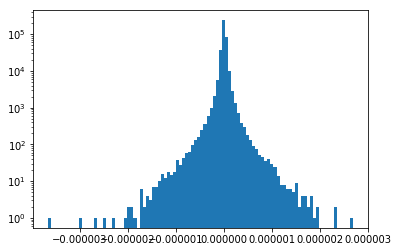

In [181]:
rel_hist(
    vint(ds, 'TPHYSTND_NORAD', C_P),
    (vint(ds, 'SPDT', C_P) + vint(ds, 'DTV', C_P))
)

-5.2528820847287365


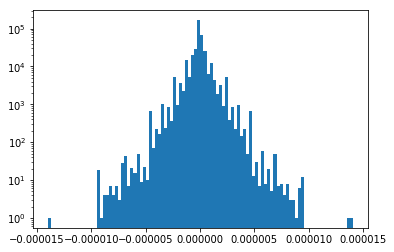

In [124]:
rel_hist(
    vint(ds, 'PHQ', L_S),
    (vint(ds, 'SPDQ', L_S) + vint(ds, 'VD01', L_S))
)

-0.03631219737881281


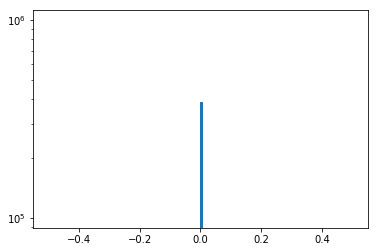

In [111]:
rel_hist(
    vint(ds, 'PHCLDLIQ', L_V),
    vint(ds, 'SPDQC', L_V)
)

-8.323711300564797


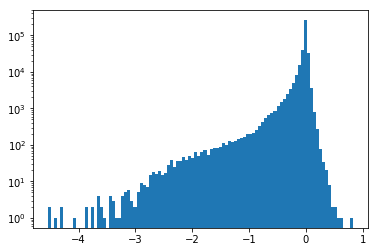

In [117]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I
# Pure SP terms
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)
rel_hist(dprec, dsp)

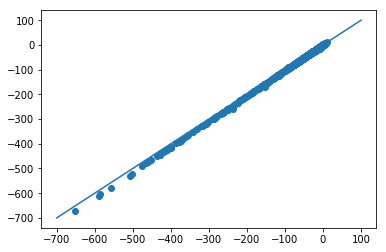

In [120]:
plt.scatter(dprec.isel(time=-1).values.flat, dsp.isel(time=-1).values.flat)
plt.plot([-700, 100], [-700, 100])

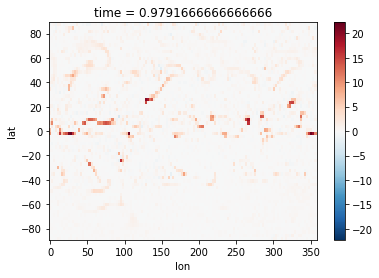

In [100]:
(dprec - dsp).isel(time=-1).plot();

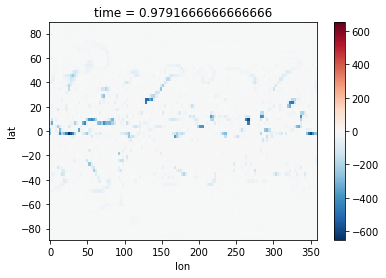

In [136]:
dprec.isel(time=-1).plot();

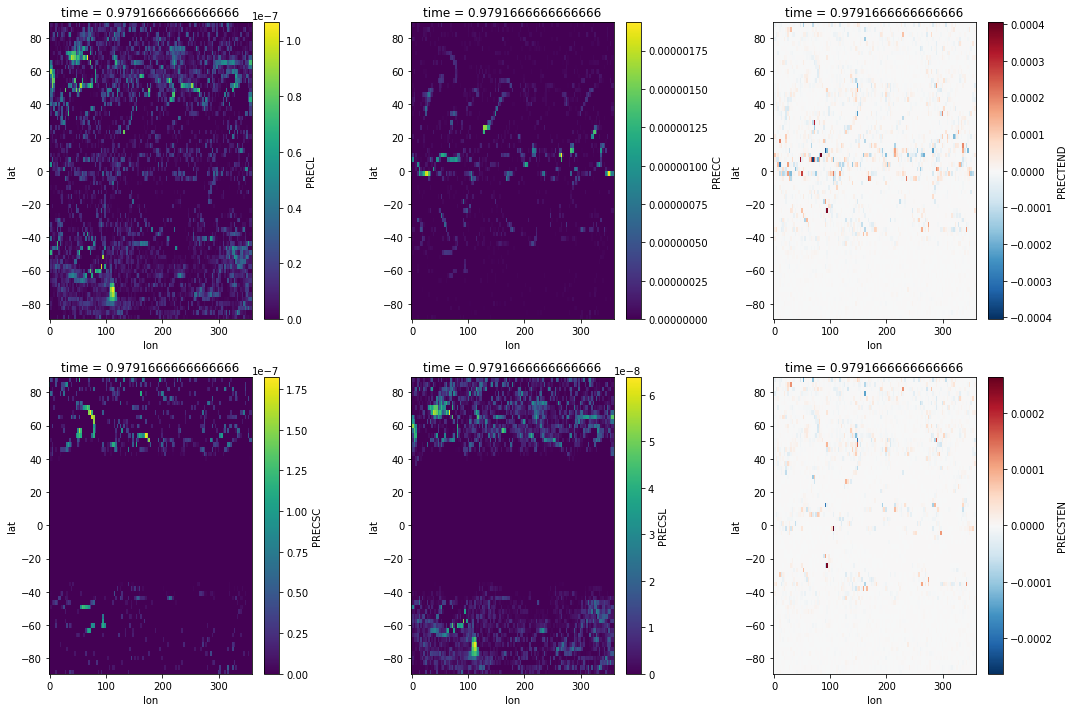

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, v in zip(axes.flat, ['PRECL', 'PRECC', 'PRECTEND', 'PRECSC', 'PRECSL', 'PRECSTEN']):
    ds[v].isel(time=-1).plot(ax=ax)
plt.tight_layout()

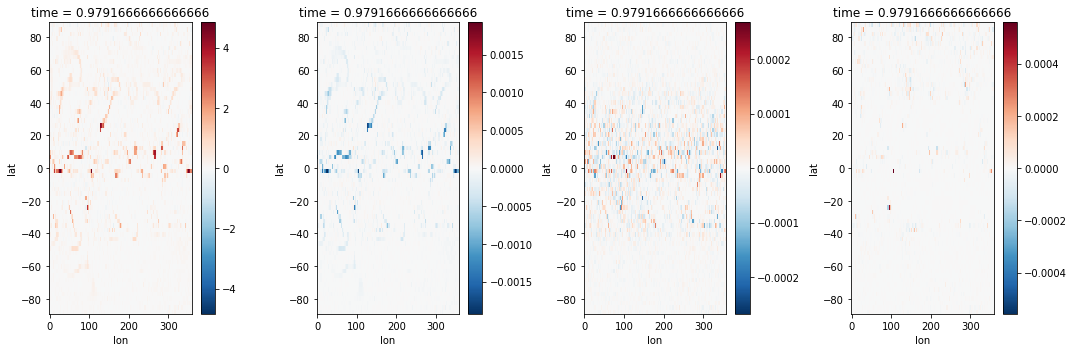

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for ax, v in zip(axes.flat, ['SPDT', 'SPDQ', 'SPDQC', 'SPDQI']):
    vint(ds, v, 1).isel(time=-1).plot(ax=ax)
plt.tight_layout()

In [182]:
dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_S)
dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)

83.44805596398238


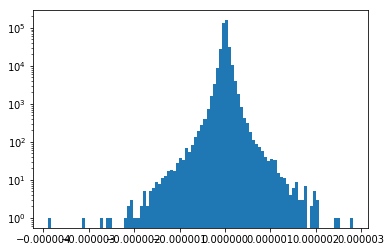

In [128]:
rel_hist(
    dconv,
    (dsp + dturb)
)

83.6231926293201


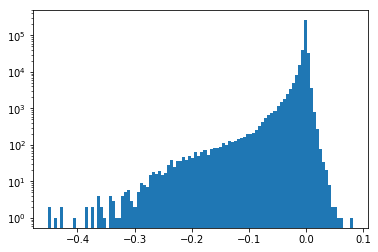

In [129]:
rel_hist(
    dconv,
    (dprec + dturb)
)

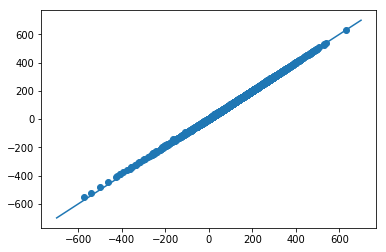

In [131]:
plt.scatter(dconv.isel(time=-1).values.flat, (dprec + dturb).isel(time=-1).values.flat)
plt.plot([-700, 700], [-700, 700])

In [184]:
dconv.std().values

array(101.56516197)

#### How important is the KE Diffusion term?

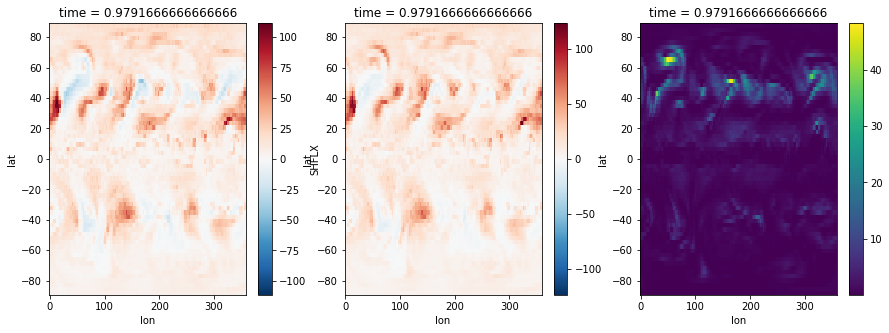

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ds.SHFLX.isel(time=-1).plot(ax=axes[0])
vint(ds, 'DTV', C_P).isel(time=-1).plot(ax=axes[1])
vint(ds, 'DTVKE', C_P/1800.).isel(time=-1).plot(ax=axes[2]);

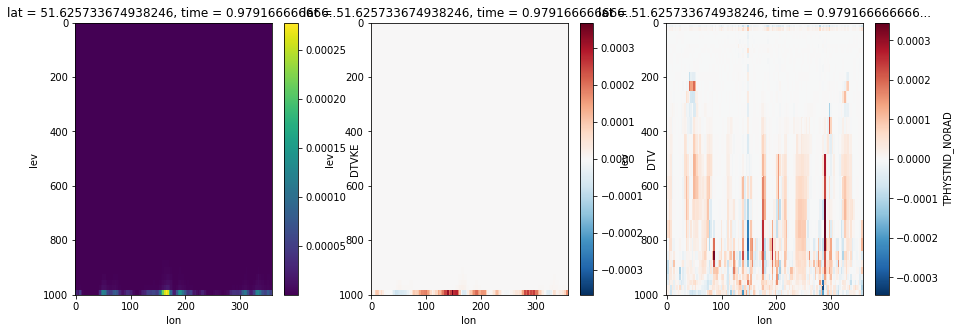

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(ds.DTVKE/1800).isel(time=-1, lat=50).plot(yincrease=False, ax=axes[0]);
ds.DTV.isel(time=-1, lat=50).plot(yincrease=False, ax=axes[1]);
ds.TPHYSTND_NORAD.isel(time=-1, lat=50).plot(yincrease=False, ax=axes[2]);

Definitely not negligible! In vertical_diffusion.F90 it seems like the application of DTVKE happens independently from the application of the surface fluxes. This means it is unaffected by FBP.

One idea would be to predict TPHYSTND_NORAD - DTVKE, because it is a source term that I cannot account for at the moment.

DTVKE is a source term of static energy. But remember DTV = DTVKE + SHFLX. It is only active at the surface though. 

#### More stuff

In [5]:
# Get statistics for a single grid point
ilat, ilon, itime = 0, 0, -1

In [6]:
a = ds.TPHYSTND_NORAD.isel(lat=ilat, lon=ilon, time=itime).values

In [7]:
def fl2hr(ds, var):
    tmp1 = G/get_dP_from_ds(ds).isel(lev=-1)
    fac = C_P if var == 'SHFLX' else L_V
    return ds[var] * tmp1 / fac

In [8]:
b = ds.SPDT.isel(lat=ilat, lon=ilon, time=itime).values
#b[-1] += fl2hr(ds, 'SHFLX').isel(lat=ilat, lon=ilon, time=itime-1).values
b[-1] += fl2hr(ds, 'SHFLX').isel(lat=ilat, lon=ilon, time=itime).values

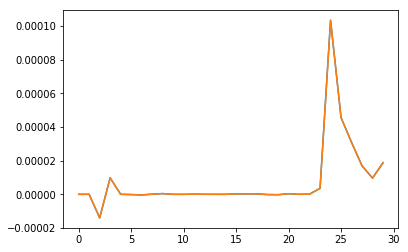

In [9]:
plt.plot(a); plt.plot(b);

In [10]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [11]:
# Surface terms
dsurf = ds.LHFLX + ds.SHFLX

In [38]:
# Turbulence terms
dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_V)

In [13]:
# Convection terms
dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)

In [14]:
# Pure SP terms
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S) + vint(ds, 'SPDQC', L_I)

In [15]:
tmp = [d.isel(time=itime, lat=ilat, lon=ilon).values for d in [dprec, dconv, dsp]]

In [16]:
#tmp += [dsurf.isel(time=itime-1, lat=ilat, lon=ilon).values]
tmp += [dsurf.isel(time=itime, lat=ilat, lon=ilon).values]

In [17]:
tmp

[array(-0.3103447, dtype=float32),
 array(19.97527367),
 array(-0.54724313),
 array(18.676828, dtype=float32)]

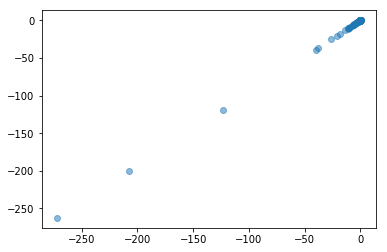

In [23]:
plt.scatter(
    dsp.isel(time=itime, lon=0).values.flat, 
    dprec.isel(time=itime, lon=0).values.flat, alpha=0.5)

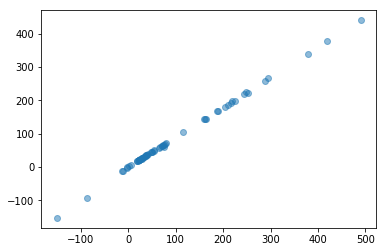

In [39]:
plt.scatter(
    dconv.isel(time=itime, lon=0).values.flat, 
    (dprec.isel(time=itime, lon=0).values + dturb.isel(time=itime, lon=0).values).flat, 
    alpha=0.5)

In [40]:
dE = (
    dconv.isel(time=itime) - 
    dprec.isel(time=itime) - 
#    dsurf.isel(time=itime-1).values
    dturb.isel(time=itime).values
)

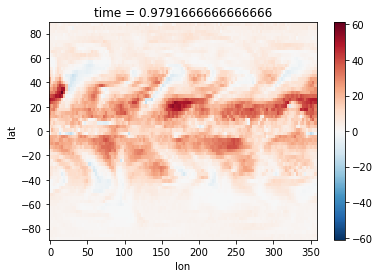

In [41]:
dE.plot();

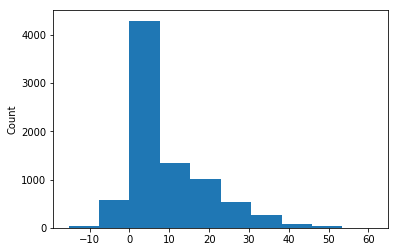

In [42]:
dE.plot.hist();

In [30]:
dE2 = (
    dsp.isel(time=itime) - 
    dprec.isel(time=itime)
)

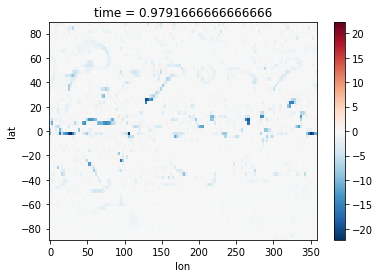

In [31]:
dE2.plot();

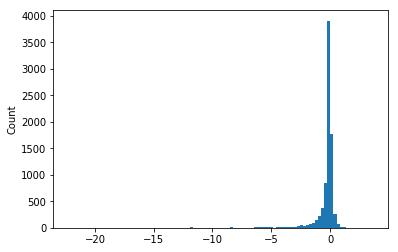

In [33]:
dE2.plot.hist(bins=100);

### Prepare data
- Inputs: ['TBP', 'QBP', 'QCBP', 'QIBP', 'DTV', 'VD01', 'PS'] --> Normalized with max(std, eps)
- Outputs: [TPHYSTND_NORAD\*C_P, PHQ\*L_S, PHCLDLIQ\*L_S, PHCLDICE\*L_S, TOT_PRECL$*24*3600*1e-2$, TOT_PRECS$*24*3600*1e-2$]
- TOT_PRECL = (PRECT\*1e3 + PRECTEND)
- TOT_PRECS = (PRECSC + PRECSL)\*1e3 + PRECSTEN

In [76]:
ds['TBP'] = ds['TAP'] - ds['TPHYSTND']*dt
ds['QBP'] = ds['QAP'] - ds['PHQ']*dt
ds['QCBP'] = ds['QCAP'] - ds['PHCLDLIQ']*dt
ds['QIBP'] = ds['QIAP'] - ds['PHCLDICE']*dt

In [77]:
ds['TOT_PRECL'] = ds['PRECT']*1e3 + ds['PRECTEND']
ds['TOT_PRECS'] = (ds['PRECSC'] + ds['PRECSL'])*1e3 + ds['PRECSTEN']

In [78]:
inpvars = ['TBP', 'QBP', 'QCBP', 'QIBP', 'DTV', 'VD01', 'PS']
outpvars = ['TPHYSTND_NORAD', 'PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TOT_PRECL', 'TOT_PRECS']

In [132]:
# According to my December thinking the factor for precip should be 1e3*24*3600 * 1e-3
# The 1e3 was already done above
# But then it's pretty small and I want it to be weighted quite a lot
outpfacts = [C_P, L_S, L_S, L_S, 24*3600*1e-2, 24*3600*1e-2]

In [134]:
f = concat_ds(ds, inpvars)

In [135]:
t = concat_ds(ds, outpvars, outpfacts)

In [136]:
f.shape, t.shape

((385024, 181), (385024, 122))

In [137]:
# Normalize features
fmeans = f.mean(0)
fstds = np.maximum(f.std(0), 1e-11)

In [138]:
norm = lambda x: (x - fmeans) / fstds
denorm = lambda x: x * fstds + fmeans

In [139]:
f = norm(f)

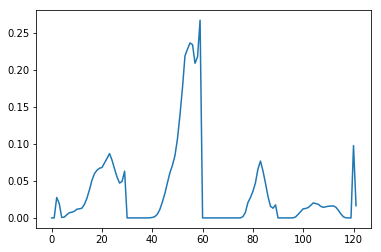

In [140]:
plt.plot(t.std(0));

In [141]:
ngeo = 64*128
def split(f, t, nt=40):
    return f[:nt*ngeo], f[nt*ngeo:], t[:nt*ngeo], t[nt*ngeo:]

In [142]:
x_trn, x_val, y_trn, y_val = split(f, t)
x_trn.shape, x_val.shape

((327680, 181), (57344, 181))

### Reference network

In [143]:
inp = Input(shape=(x_trn.shape[1],))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(y_trn.shape[1])(x)
net = keras.models.Model(inp, outp)

In [144]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 181)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               46592     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 122)               31354     
Total params: 143,738
Trainable params: 143,738
Non-trainable params: 0
_________________________________________________________________


In [145]:
net.compile('adam', 'mse')

In [146]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0112 - val_loss: 0.0040
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0037 - val

In [147]:
net.optimizer.lr = 1e-4
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0028 - val

In [148]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/10
327680/327680 [==============================] - 4s 12us/step - loss: 0.0027 - val

In [149]:
preds = net.predict(x_val, 4048)

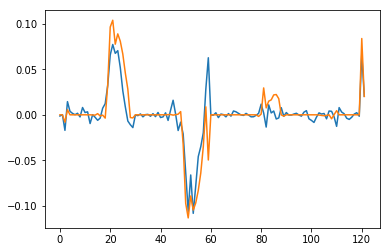

In [150]:
i=2000
plt.plot(preds[i]); plt.plot(y_val[i])

In [151]:
preds_re = preds.reshape(-1, 64, 128, preds.shape[-1])
val_re = y_val.reshape(-1, 64, 128, preds.shape[-1])

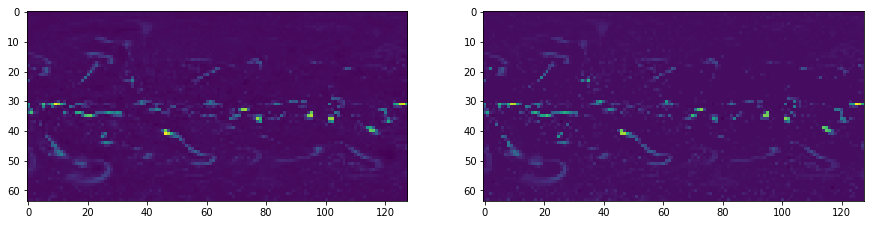

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(preds_re[0, : , :, -2])
axes[1].imshow(val_re[0, : , :, -2]);

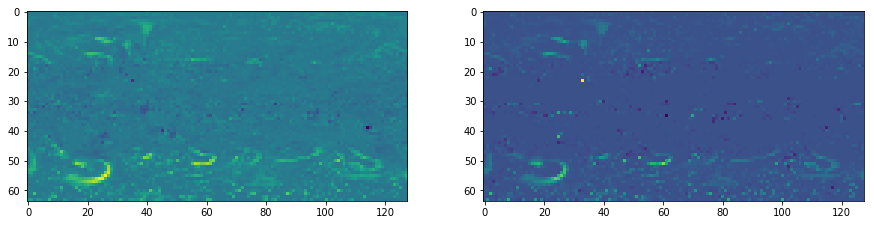

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(preds_re[0, : , :, -1])
axes[1].imshow(val_re[0, : , :, -1]);

### Numpy energy conservation layer

In [130]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

- dturb = vint(ds, 'DTV', C_P) + vint(ds, 'VD01', L_S)
- dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) + vint(ds, 'PHCLDLIQ', L_I)
- dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [ ]:
def np_energy_layer(arrs):
    """
    - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
    - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
    f(eatures) -> 62 layers
    a(ctivations) -> 63 layers
    """
    f, a = arrs
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(a[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(a[:, -30:]*dP/G, 1)
    F2to4 = np.sum(a[:, :3], 1) * 1e4
    F1 = (vintQRL + vintQRS - F2to4) / 1e4
    return np.concatenate([np.reshape(F1, (-1, 1)), a], 1)

In [171]:
def vint_np(a, dP): return np.sum(a*dP/G, 1)

In [223]:
def np_mse_layer(arrs):
    # Destructure input arrays
    f, a = arrs
#     pdb.set_trace()
    # Split arrays
    tmp = f * fstds + fmeans
    DTV, VD01, PS = tmp[:,120:150], tmp[:,150:180], tmp[:,-1]   # Now in actual units
    TPHY, PHQ, PHQC, PHQI, PRECL, PRECS = a[:, :30], a[:, 30:60], a[:, 60:90], a[:, 90:120], a[:, 120], a[:, 121]
    # Get pressure differences
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Compute vertical integrals and convert to energy units
    vDTV, vVD01, vTPHY = vint_np(DTV, dP)*C_P, vint_np(VD01, dP)*L_S, vint_np(TPHY, dP)
    vPHQ, vPHQC, vPHQI = vint_np(PHQ, dP), vint_np(PHQC, dP)/L_S*L_I, vint_np(PHQI, dP)
    # Compute precip energy sink
    dPREC = (PRECS/(24*3600*1e-2) - PRECL/(24*3600*1e-2))*L_I
    # Compute convective and turbulent totals
    dCONV = vTPHY + vPHQ + vPHQC
    dTURB = vDTV + vVD01
    # Compute energy loss
    dE = dCONV - dTURB - dPREC
    return dCONV, dTURB, dPREC, dE

In [219]:
tmp = np_mse_layer([x_val[-ngeo:], y_val[-ngeo:]])

> <ipython-input-218-e5e61ef31013>(6)np_mse_layer()
-> tmp = f * fstds + fmeans
(Pdb) c


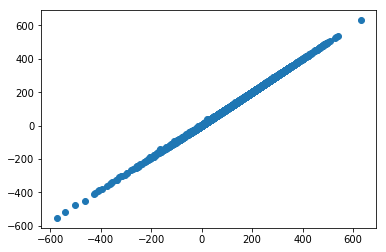

In [222]:
plt.scatter(tmp[0].flat, (tmp[1]+tmp[2]).flat)

## Radiation conservation

vint(QRL)C_P + vint(QRS)C_P = FSNT - FSNS -FLNT + FLNS

In [4]:
n_days = 1

In [5]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/fluxbypass_aqua/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_sp_fbp_f2.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [6]:
ds = ds.isel(time=slice(1, None))

In [10]:
ds['TBP'] = ds['TAP'] - ds['TPHYSTND']*dt
ds['QBP'] = ds['QAP'] - ds['PHQ']*dt

In [11]:
print(sorted(list(ds.data_vars.keys())))

['DTV', 'FLNS', 'FLNT', 'FLUT', 'FSNS', 'FSNT', 'LHFLX', 'P0', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QBP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDT', 'T', 'TAP', 'TBP', 'TPHYSTND', 'TS', 'UAP', 'VAP', 'VD01', 'date', 'date_written', 'datesec', 'gw', 'hyai', 'hyam', 'hybi', 'hybm', 'mdt', 'nbdate', 'nbsec', 'ndbase', 'ndcur', 'nlon', 'nsbase', 'nscur', 'nsteph', 'ntrk', 'ntrm', 'ntrn', 'time_bnds', 'time_written', 'wnummax']


In [41]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

### What are these F terms anyway?

In [225]:
ds.FSNT.long_name

'Net solar flux at top of model'

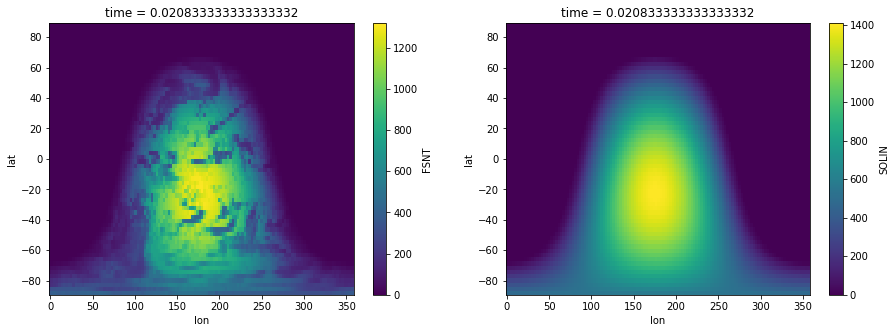

In [226]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FSNT.isel(time=1).plot(ax=axes[0])
ds.SOLIN.isel(time=1).plot(ax=axes[1]);

In [420]:
ds.FSNS.long_name

'Net solar flux at surface'

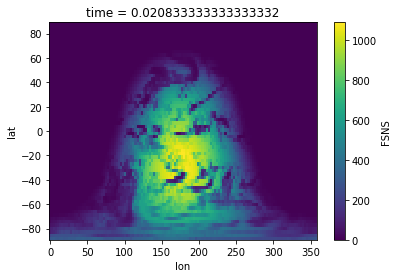

In [422]:
ds.FSNS.isel(time=1).plot();

In [424]:
ds.FLNT.long_name

'Net longwave flux at top of model'

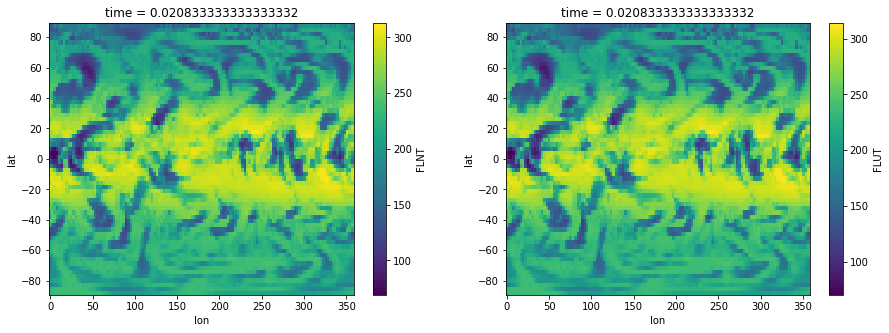

In [425]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FLNT.isel(time=1).plot(ax=axes[0])
ds.FLUT.isel(time=1).plot(ax=axes[1]);

In [426]:
ds.FLNS.long_name

'Net longwave flux at surface'

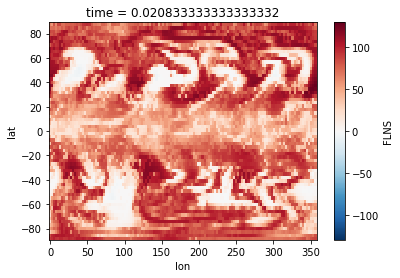

In [427]:
ds.FLNS.isel(time=1).plot();

### Test from raw data

In [227]:
flx_net = ds.FSNT - ds.FSNS - ds.FLNT + ds.FLNS

In [228]:
drad = vint(ds, 'QRL', C_P) + vint(ds, 'QRS', C_P)

In [229]:
ilat, ilon, itime = 32, 0, -1

In [230]:
flx_net.isel(time=itime, lat=ilat, lon=ilon).values

array(-97.08189, dtype=float32)

In [231]:
drad.isel(time=itime, lat=ilat, lon=ilon).values

array(-96.59567565)

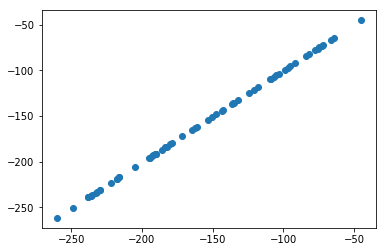

In [232]:
plt.scatter(drad.isel(lon=0, time=itime), flx_net.isel(lon=0, time=itime));

### Prepare data

- Inputs: [PS, SOLIN, TAP(z), QAP(z)]
- Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]

In [22]:
inpvars = ['PS', 'SOLIN', 'TBP', 'QBP']
outpvars = ['FSNT', 'FSNS', 'FLNT', 'FLNS', 'QRL', 'QRS']
outpfacts = [1e-4, -1e-4, -1e-4, 1e-4, C_P, C_P]

In [13]:
f = concat_ds(ds, inpvars)

In [15]:
# Normalize features
fmeans = f.mean(0)
fstds = f.std(0) # np.maximum(f.std(0), 1e-11)

In [18]:
norm = lambda x: (x - fmeans) / fstds
denorm = lambda x: x * fstds + fmeans

In [19]:
f = norm(f)

In [23]:
t = concat_ds(ds, outpvars, outpfacts)

In [26]:
x_trn, x_val, y_trn, y_val = split(f, t, 40)
x_trn.shape, x_val.shape

((327680, 62), (57344, 62))

### Reference network

In [29]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(64)(x)
net = keras.models.Model(inp, outp)

In [30]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 62)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16128     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
Total params: 98,368
Trainable params: 98,368
Non-trainable params: 0
_________________________________________________________________


In [31]:
net.compile('adam', 'mse')

In [32]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 0.0034 - val_loss: 4.5432e-04
Epoch 2/10
327680/327680 [==============================] - 3s 10us/step - loss: 3.6723e-04 - val_loss: 2.8093e-04
Epoch 3/10
327680/327680 [==============================] - 3s 9us/step - loss: 2.6910e-04 - val_loss: 2.2274e-04
Epoch 4/10
327680/327680 [==============================] - 3s 10us/step - loss: 2.2856e-04 - val_loss: 1.9453e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 2.0613e-04 - val_loss: 1.7676e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.9143e-04 - val_loss: 1.6663e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.8085e-04 - val_loss: 1.5742e-04
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.7255e-04 - val_loss: 1.5059e-04
Epoch 9/10
327680/327680 [========

In [33]:
net.optimizer.lr = 1e-4

In [34]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.5589e-04 - val_loss: 1.4086e-04
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.5120e-04 - val_loss: 1.3387e-04
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.4674e-04 - val_loss: 1.3280e-04
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.4202e-04 - val_loss: 1.2718e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3902e-04 - val_loss: 1.2874e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3497e-04 - val_loss: 1.2582e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.3112e-04 - val_loss: 1.2098e-04
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.2834e-04 - val_loss: 1.1653e-04
Epoch 9/10
327680/327680 [===

In [35]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1766e-04 - val_loss: 1.1340e-04
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1514e-04 - val_loss: 1.0762e-04
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.1273e-04 - val_loss: 1.0666e-04
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0954e-04 - val_loss: 1.0320e-04
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0701e-04 - val_loss: 1.0054e-04
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0523e-04 - val_loss: 1.0098e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0274e-04 - val_loss: 9.5667e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 1.0107e-04 - val_loss: 9.5761e-05
Epoch 9/10
327680/327680 [===

In [36]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.5711e-05 - val_loss: 9.1961e-05
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.3801e-05 - val_loss: 9.0748e-05
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.2182e-05 - val_loss: 8.7448e-05
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 9.1300e-05 - val_loss: 8.8365e-05
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.9887e-05 - val_loss: 8.6831e-05
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.8411e-05 - val_loss: 8.8041e-05
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.6573e-05 - val_loss: 8.7074e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.6706e-05 - val_loss: 8.3193e-05
Epoch 9/10
327680/327680 [===

In [37]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.2694e-05 - val_loss: 8.2517e-05
Epoch 2/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.2161e-05 - val_loss: 8.0560e-05
Epoch 3/10
327680/327680 [==============================] - 4s 11us/step - loss: 8.1368e-05 - val_loss: 8.2258e-05
Epoch 4/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.9909e-05 - val_loss: 7.9680e-05
Epoch 5/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.9196e-05 - val_loss: 8.1866e-05
Epoch 6/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.8089e-05 - val_loss: 7.7358e-05
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.7600e-05 - val_loss: 8.0473e-05
Epoch 8/10
327680/327680 [==============================] - 4s 11us/step - loss: 7.6926e-05 - val_loss: 7.8058e-05
Epoch 9/10
327680/327680 [===

In [38]:
def get_dE(x, y):
    PS = x[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(y[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(y[:, -30:]*dP/G, 1)
    #F1to3 = np.sum(y[:, :3]*signs[:3], 1) * 1e4
    F1to4 = np.sum(y[:, :4], 1) * 1e4
    #F4 = (vintQRL + vintQRS - F1to3) / 1e4
    #out_y = np.concatenate([y, np.reshape(F4, (-1, 1))], 1)
    return vintQRL + vintQRS, F1to4

In [39]:
def check_preds(m, s='val'):
    x, y = (x_val, y_val) if s == 'val' else (x_trn, y_trn)
    preds = m.predict(x, batch_size=1024)
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for ax in axes.flat:
        idx = np.random.randint(0, x.shape[0])
        ax.plot(y[idx]); ax.plot(preds[idx])
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    a, b = get_dE(x, preds)
    axes[0].hist(a - b, bins=100)
    mse = np.mean((preds - y)**2, 0); var = np.var(y, 0)
    r2 = 1 - (mse/var)
    axes[1].plot(r2); axes[1].scatter(range(4), r2[:4])
    axes[1].set_ylim(0,1); axes[1].set_xlim(0, r2.size)

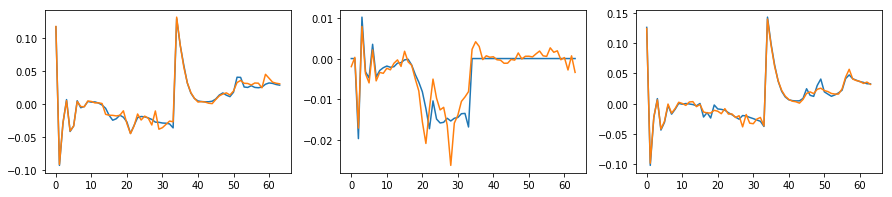

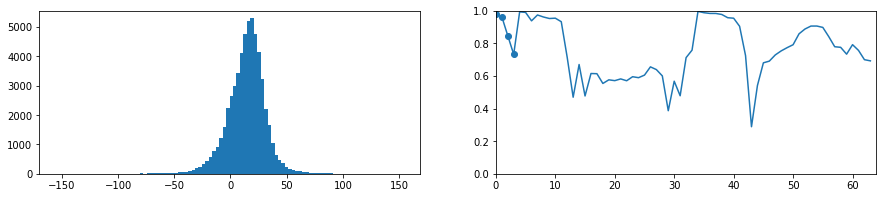

In [40]:
check_preds(net)

### Now with energy conservation

#### First the dry run

In [42]:
def np_energy_layer_rad(arrs):
    """
    - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
    - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
    f(eatures) -> 62 layers
    a(ctivations) -> 63 layers
    """
    f, a = arrs
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(a[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(a[:, -30:]*dP/G, 1)
    F2to4 = np.sum(a[:, :3], 1) * 1e4
    F1 = (vintQRL + vintQRS - F2to4) / 1e4
    return np.concatenate([np.reshape(F1, (-1, 1)), a], 1)

In [43]:
test = np_energy_layer_rad([x_val, np.random.rand(x_val.shape[0], 63)])

In [44]:
get_dE(x_val, test)

(array([10674.29284491, 10368.93431925, 10259.12615904, ...,
        10352.39121457,  8968.96745292, 10845.61013344]),
 array([10674.29284491, 10368.93431925, 10259.12615904, ...,
        10352.39121457,  8968.96745292, 10845.61013344]))

#### Now implement into NN

In [47]:
class ConservationLayerRad(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        """
        - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
        - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
        f(eatures) -> 62 layers
        a(ctivations) -> 63 layers
        """
        f, a = arrs
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        vintQRL = K.sum(a[:, -60:-30]*dP/G, 1)
        vintQRS = K.sum(a[:, -30:]*dP/G, 1)
        F2to4 = K.sum(a[:, :3], 1) * 1e4
        F1 = (vintQRL + vintQRS - F2to4) / 1e4
        return K.concatenate([K.reshape(F1, (-1, 1)), a], 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[1][0], input_shape[1][1]+1)

In [48]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(63)(x)
outp = ConservationLayerRad()([inp, tmp])
enet = keras.models.Model(inp, outp)

In [49]:
enet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 62)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          16128       input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 256)          0           dense_7[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          65792       leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [50]:
enet.compile('adam', 'mse')

In [51]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.0034 - val_loss: 4.6090e-04
Epoch 2/10
327680/327680 [==============================] - 4s 12us/step - loss: 3.7326e-04 - val_loss: 2.8225e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 2.6918e-04 - val_loss: 2.2185e-04
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 2.2677e-04 - val_loss: 1.9219e-04
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 2.0420e-04 - val_loss: 1.7553e-04
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.9099e-04 - val_loss: 1.6846e-04
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.8211e-04 - val_loss: 1.5914e-04
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.7324e-04 - val_loss: 1.5306e-04
Epoch 9/10
327680/327680 [=======

In [52]:
enet.optimizer.lr = 1e-4

In [53]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 1.5730e-04 - val_loss: 1.4089e-04
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.5262e-04 - val_loss: 1.3525e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.4868e-04 - val_loss: 1.3419e-04
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 1.4438e-04 - val_loss: 1.2948e-04
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.4051e-04 - val_loss: 1.2723e-04
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.3697e-04 - val_loss: 1.2365e-04
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.3310e-04 - val_loss: 1.1897e-04
Epoch 8/10
327680/327680 [==============================] - 4s 12us/step - loss: 1.2942e-04 - val_loss: 1.1795e-04
Epoch 9/10
327680/327680 [===

In [54]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.2040e-04 - val_loss: 1.1528e-04
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1714e-04 - val_loss: 1.0905e-04
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1485e-04 - val_loss: 1.0590e-04
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.1144e-04 - val_loss: 1.0342e-04
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0919e-04 - val_loss: 9.9894e-05
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0669e-04 - val_loss: 9.9383e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0397e-04 - val_loss: 9.8552e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 1.0272e-04 - val_loss: 9.8152e-05
Epoch 9/10
327680/327680 [===

In [55]:
enet.optimizer.lr = 1e-5
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 12us/step - loss: 9.6639e-05 - val_loss: 9.4563e-05
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.4881e-05 - val_loss: 9.2356e-05
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.3652e-05 - val_loss: 8.9546e-05
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 9.2221e-05 - val_loss: 8.6367e-05
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 9.0357e-05 - val_loss: 8.6106e-05
Epoch 6/10
327680/327680 [==============================] - 4s 12us/step - loss: 8.9598e-05 - val_loss: 8.6319e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.7978e-05 - val_loss: 8.7097e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.6326e-05 - val_loss: 8.3553e-05
Epoch 9/10
327680/327680 [===

In [56]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.3276e-05 - val_loss: 8.0760e-05
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.2489e-05 - val_loss: 8.1146e-05
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 8.1626e-05 - val_loss: 8.0813e-05
Epoch 4/10
327680/327680 [==============================] - 4s 12us/step - loss: 8.0199e-05 - val_loss: 7.9020e-05
Epoch 5/10
327680/327680 [==============================] - 4s 12us/step - loss: 7.9972e-05 - val_loss: 7.7783e-05
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.8920e-05 - val_loss: 7.8651e-05
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.8121e-05 - val_loss: 7.9352e-05
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 7.7347e-05 - val_loss: 7.4696e-05
Epoch 9/10
327680/327680 [===

In [57]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.5429e-05 - val_loss: 7.4297e-05
Epoch 2/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.5031e-05 - val_loss: 7.2827e-05
Epoch 3/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.3388e-05 - val_loss: 7.3659e-05
Epoch 4/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.3186e-05 - val_loss: 7.4299e-05
Epoch 5/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.2822e-05 - val_loss: 7.4604e-05
Epoch 6/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.2318e-05 - val_loss: 7.3345e-05
Epoch 7/15
327680/327680 [==============================] - 4s 12us/step - loss: 7.1788e-05 - val_loss: 7.0782e-05
Epoch 8/15
327680/327680 [==============================] - 4s 13us/step - loss: 7.1438e-05 - val_loss: 7.2443e-05
Epoch 9/15
327680/327680 [===

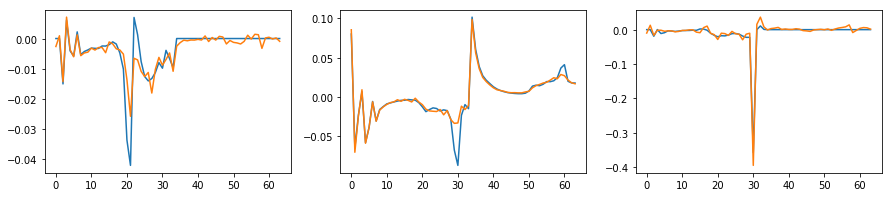

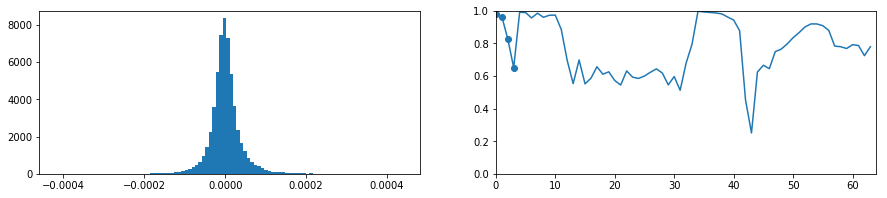

In [58]:
check_preds(enet)

### Version 2: Spread the energy around additively

#### Numpy version

In [128]:
def np_energy_layer_rad2(arrs):
    """
    """
    
    f, a = arrs[0].copy(), arrs[1].copy()
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Get heating rates per layer in energy units
    eQRL = a[:, -60:-30]*dP/G
    eQRS = a[:, -30:]*dP/G
    vintQRL_abs = np.sum(np.abs(eQRL), 1)
    vintQRS_abs = np.sum(np.abs(eQRS), 1)
    vintQRL = np.sum(eQRL, 1)
    vintQRS = np.sum(eQRS, 1)
    F1to4 = np.sum(a[:, :4], 1) * 1e4
    dE = vintQRL + vintQRS - F1to4
    # Compute correction terms and convert back to heating rates
    #pdb.set_trace()
    fact = np.abs(eQRL) / vintQRL_abs[:, None] / 2.
    fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRL_corr = (dE[:, None] * fact) /dP*G
    fact = np.abs(eQRS) / vintQRS_abs[:, None] / 2.
    fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
    QRS_corr = (dE[:, None] * fact) /dP*G
    a[:, -60:-30] -= QRL_corr
    a[:, -30:] -= QRS_corr
    totvint = None

    
    return a, dE, fact, F1to4, totvint

In [129]:
tmp, dE, fact, F1to4, totvint = np_energy_layer_rad2([x_val, np.random.rand(x_val.shape[0], 64)])

In [130]:
dE

array([-17455.57147583, -11031.78294258,  -9372.90910625, ...,
       -21719.25113836, -10886.23875208,  -3838.51001045])

In [131]:
tmp, dE, fact, F1to4, totvint = np_energy_layer_rad2([x_val, tmp])

In [132]:
dE

array([ 0.00000000e+00,  0.00000000e+00, -3.63797881e-12, ...,
        1.09139364e-11, -3.63797881e-12,  3.63797881e-12])

8.997871190157


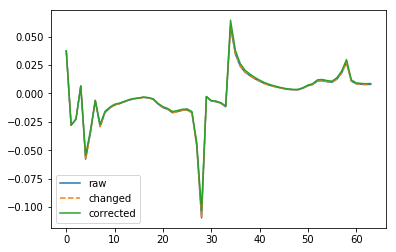

In [342]:
i=1
print(dE[i])
plt.plot(y_val[i], label='raw'); plt.plot(tmp_y[i], label='changed', ls='--'); plt.plot(tmp[i], label='corrected');
plt.legend();

#### Implementation

In [133]:
class ConservationLayerRad2(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        out = a
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        # Get heating rates per layer in energy units
        eQRL = a[:, -60:-30]*dP/G
        eQRS = a[:, -30:]*dP/G
        vintQRL_abs = K.sum(K.abs(eQRL), 1)
        vintQRS_abs = K.sum(K.abs(eQRS), 1)
        vintQRL = K.sum(eQRL, 1)
        vintQRS = K.sum(eQRS, 1)
        F1to4 = K.sum(a[:, :4], 1) * 1e4
        dE = vintQRL + vintQRS - F1to4
        
        # Compute correction terms and convert back to heating rates
        fact = K.abs(eQRL) / vintQRL_abs[:, None] / 2.
        fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRL_corr = (dE[:, None] * fact) /dP*G
        fact = K.abs(eQRS) / vintQRS_abs[:, None] / 2.
        fact = tf.where(tf.is_nan(fact), K.zeros_like(fact), fact)
        QRS_corr = (dE[:, None] * fact) /dP*G
        b = a[:, -60:-30] - QRL_corr
        c = a[:, -30:] - QRS_corr

        return K.concatenate([a[:, :4], b, c], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [149]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(64)(x)
outp = ConservationLayerRad2()([inp, tmp])
enet2 = keras.models.Model(inp, outp)

In [150]:
enet2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 256)          16128       input_13[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 256)          0           dense_19[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 256)          65792       leaky_re_lu_13[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [151]:
enet2.compile('adam', 'mse')

In [152]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 16us/step - loss: 0.0072 - val_loss: 7.2070e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 5.8498e-04 - val_loss: 4.9049e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 4.4693e-04 - val_loss: 3.9157e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 4.4601e-04 - val_loss: 3.5209e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 4.0994e-04 - val_loss: 3.1042e-04
Epoch 6/10
327680/327680 [==============================] - 5s 14us/step - loss: 3.8891e-04 - val_loss: 2.9094e-04
Epoch 7/10
327680/327680 [==============================] - 4s 11us/step - loss: 3.5312e-04 - val_loss: 3.2710e-04
Epoch 8/10
327680/327680 [==============================] - 5s 14us/step - loss: 3.4964e-04 - val_loss: 4.6518e-04
Epoch 9/10
327680/327680 [=======

In [153]:
enet2.optimizer.lr = 1e-5
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.8333e-04 - val_loss: 2.4532e-04
Epoch 2/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.7733e-04 - val_loss: 4.9409e-04
Epoch 3/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.6553e-04 - val_loss: 2.3072e-04
Epoch 4/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.5452e-04 - val_loss: 2.1623e-04
Epoch 5/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.4890e-04 - val_loss: 2.1383e-04
Epoch 6/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.3501e-04 - val_loss: 1.9295e-04
Epoch 7/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.3480e-04 - val_loss: 1.9433e-04
Epoch 8/10
327680/327680 [==============================] - 5s 15us/step - loss: 2.2429e-04 - val_loss: 2.1881e-04
Epoch 9/10
327680/327680 [===

In [156]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=20, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/20
327680/327680 [==============================] - 5s 16us/step - loss: 1.4444e-04 - val_loss: 1.3399e-04
Epoch 2/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.3985e-04 - val_loss: 1.3562e-04
Epoch 3/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.3576e-04 - val_loss: 1.2901e-04
Epoch 4/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.3170e-04 - val_loss: 1.2902e-04
Epoch 5/20
327680/327680 [==============================] - 5s 16us/step - loss: 1.2906e-04 - val_loss: 1.2400e-04
Epoch 6/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.2624e-04 - val_loss: 1.1989e-04
Epoch 7/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.2236e-04 - val_loss: 1.2107e-04
Epoch 8/20
327680/327680 [==============================] - 5s 15us/step - loss: 1.2009e-04 - val_loss: 1.1689e-04
Epoch 9/20
327680/327680 [===

In [157]:
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=20, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/20
327680/327680 [==============================] - 5s 15us/step - loss: 9.7714e-05 - val_loss: 9.9993e-05
Epoch 2/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.5629e-05 - val_loss: 9.7995e-05
Epoch 3/20
327680/327680 [==============================] - 5s 15us/step - loss: 9.5245e-05 - val_loss: 9.6621e-05
Epoch 4/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.4335e-05 - val_loss: 9.8738e-05
Epoch 5/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.2566e-05 - val_loss: 9.3218e-05
Epoch 6/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.2387e-05 - val_loss: 9.5065e-05
Epoch 7/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.0584e-05 - val_loss: 9.2502e-05
Epoch 8/20
327680/327680 [==============================] - 5s 16us/step - loss: 9.0370e-05 - val_loss: 9.4532e-05
Epoch 9/20
327680/327680 [===

In [182]:
enet2.optimizer.lr = 1e-5
enet2.fit(x_trn, y_trn, batch_size=1024, epochs=20, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/20
327680/327680 [==============================] - 5s 15us/step - loss: 8.2364e-05 - val_loss: 8.5521e-05
Epoch 2/20
327680/327680 [==============================] - 5s 15us/step - loss: 8.0947e-05 - val_loss: 8.2242e-05
Epoch 3/20
327680/327680 [==============================] - 5s 16us/step - loss: 8.1429e-05 - val_loss: 8.5006e-05
Epoch 4/20
327680/327680 [==============================] - 5s 15us/step - loss: 7.9823e-05 - val_loss: 8.6696e-05
Epoch 5/20
327680/327680 [==============================] - 5s 16us/step - loss: 7.9683e-05 - val_loss: 8.3692e-05
Epoch 6/20
327680/327680 [==============================] - 5s 15us/step - loss: 7.9386e-05 - val_loss: 8.4825e-05
Epoch 7/20
327680/327680 [==============================] - 5s 15us/step - loss: 7.9113e-05 - val_loss: 8.4504e-05
Epoch 8/20
327680/327680 [==============================] - 5s 15us/step - loss: 7.8170e-05 - val_loss: 8.2396e-05
Epoch 9/20
327680/327680 [===

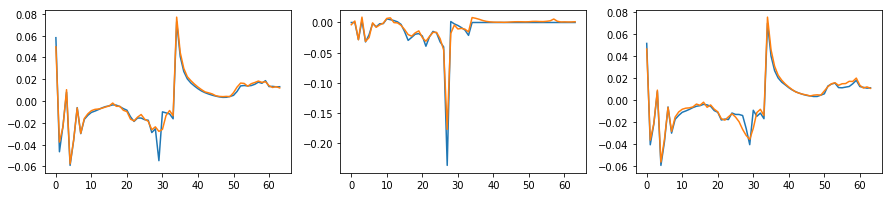

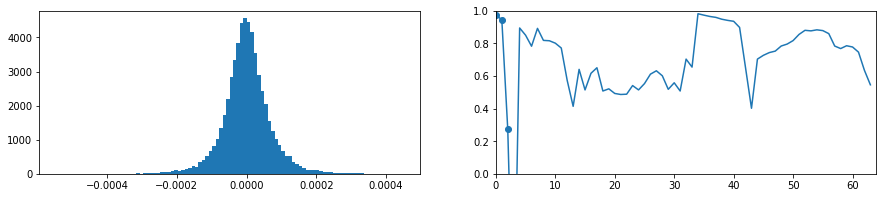

In [184]:
check_preds(enet2)

### Version 3 - spread multiplicatively

#### Numpy

In [168]:
def np_energy_layer_rad3(arrs, is_mult=True):
    """
    """
    
    f, a = arrs[0].copy(), arrs[1].copy()
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    # Get heating rates per layer in energy units
    eQRL = a[:, -60:-30]*dP/G
    eQRS = a[:, -30:]*dP/G
    vintQRL_abs = np.sum(np.abs(eQRL), 1)
    vintQRS_abs = np.sum(np.abs(eQRS), 1)
    vintQRL = np.sum(eQRL, 1)
    vintQRS = np.sum(eQRS, 1)
    F1to4 = np.sum(a[:, :4], 1) * 1e4
    dE = vintQRL + vintQRS - F1to4
    # Compute correction terms and convert back to heating rates
    if not is_mult:
        #pdb.set_trace()
        fact = np.abs(eQRL) / vintQRL_abs[:, None] / 2.
        fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
        QRL_corr = (dE[:, None] * fact) /dP*G
        fact = np.abs(eQRS) / vintQRS_abs[:, None] / 2.
        fact = np.where(np.isnan(fact), np.zeros_like(fact), fact)
        QRS_corr = (dE[:, None] * fact) /dP*G
        a[:, -60:-30] -= QRL_corr
        a[:, -30:] -= QRS_corr
        totvint = None
    # Multiplicative version
    else:
        totvint = vintQRL + vintQRS
        fact = F1to4 / totvint
        a[:, -60:] *= fact[:, None]
    
    return a, dE, fact, F1to4, totvint

In [169]:
tmp, dE, fact, F1to4, totvint = np_energy_layer_rad3([x_val, np.random.rand(x_val.shape[0], 64)])

In [170]:
dE

array([ -6607.44461657, -16660.28626513, -19742.62820024, ...,
        -5509.15497182,  -2805.58109513, -15290.45130801])

In [171]:
tmp, dE, fact, F1to4, totvint = np_energy_layer_rad2([x_val, tmp])

In [172]:
dE

array([ 7.27595761e-12, -3.63797881e-12, -3.63797881e-12, ...,
        1.81898940e-12, -1.81898940e-12,  3.63797881e-12])

#### Implementation

In [159]:
class ConservationLayerRad3(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        f, a = arrs
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        # Get heating rates per layer in energy units
        eQRL = a[:, -60:-30]*dP/G
        eQRS = a[:, -30:]*dP/G
        vintQRL_abs = K.sum(K.abs(eQRL), 1)
        vintQRS_abs = K.sum(K.abs(eQRS), 1)
        vintQRL = K.sum(eQRL, 1)
        vintQRS = K.sum(eQRS, 1)
        F1to4 = K.sum(a[:, :4], 1) * 1e4
        dE = vintQRL + vintQRS - F1to4

        totvint = vintQRL + vintQRS
        fact = F1to4 / totvint
        out = a[:, -60:] * fact[:, None]

        return K.concatenate([a[:, :4], out], 1)

    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [160]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(64)(x)
outp = ConservationLayerRad3()([inp, tmp])
enet3 = keras.models.Model(inp, outp)

In [161]:
enet3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 256)          16128       input_14[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 256)          0           dense_22[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 256)          65792       leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [162]:
enet3.compile('adam', 'mse')

In [179]:
enet.optimizer.lr=1e-6

In [180]:
enet3.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 327680 samples, validate on 57344 samples
Epoch 1/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2933 - val_loss: 0.1809
Epoch 2/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2670 - val_loss: 0.1633
Epoch 3/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2425 - val_loss: 0.1508
Epoch 4/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2229 - val_loss: 0.1404
Epoch 5/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.2019 - val_loss: 0.1304
Epoch 6/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1852 - val_loss: 0.1246
Epoch 7/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1717 - val_loss: 0.1190
Epoch 8/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.1557 - val_loss: 0.1163
Epoch 9/10
327680/327680 [==============================] - 4s 13us/step - loss: 0.5408 - val

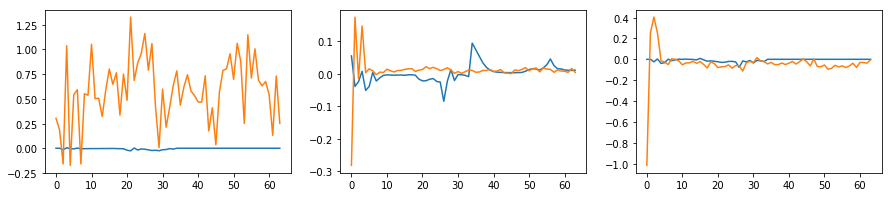

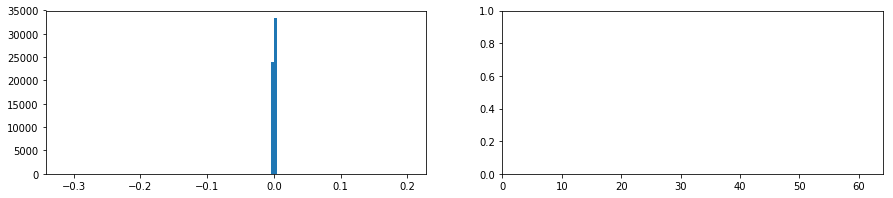

In [181]:
check_preds(enet3)